## Climate Policies Under Wealth Inequality
This notebook is meant to reproduce the results shown in the paper "Climate policies under wealth inequality", linked here: https://www.pnas.org/doi/10.1073/pnas.1323479111. 

#### Abstract of the paper:
(verbatim) Taming the planet’s climate requires cooperation. Previous failures to reach consensus in climate summits have been attributed, among other factors, to conflicting policies between rich and poor countries, which disagree on the implementation of mitigation measures. Here we implement wealth inequality in a threshold public goods dilemma of cooperation in which players also face the risk of potential future losses. We consider a population exhibiting an asymmetric distribution of rich and poor players that reflects the present-day status of nations and study the behavioral interplay between rich and poor in time, regarding their willingness to cooperate. Individuals are also allowed to exhibit a variable degree of homophily, which acts to limit those that constitute one’s sphere of influence. Under the premises of our model, and in the absence of homophily, comparison between scenarios with wealth inequality and without wealth inequality shows that the former leads to more global cooperation than the latter. Furthermore, we find that the rich generally contribute more than the poor and will often compensate for the lower contribution of the latter. Contributions from the poor, which are crucial to overcome the climate change dilemma, are shown to be very sensitive to homophily, which, if prevalent, can lead to a collapse of their overall contribution. In such cases, however, we also find that obstinate cooperative behavior by a few poor may largely compensate for homophilic behavior.

To achieve the results of the paper, we have created a Public Goods Game (PGG) to model the climate policies game.

In [1]:
#!pip install egttools numpy matplotlib > /dev/null 2>&1

Questions:
1. Is it possible to use AbstractNPlayerGame - even though it doesn't directly provide functions to split populations into two distint groups with different behaviors?
2. Should we be drawing up a payoff matrix? Can it really capture the subtleties of this model?
3. Can we use PairwiseComparison - given our use case needs to be evolved using custom methods, based on homophily and "obstinate" mutations.
4. Can a simplex be drawn with just two axis/two populations using plot_replicator_dynamics_in_simplex? I think not, but checking if there is another way?
5. PairwiseComparison/PairwiseComparisonNumerical all consider movement between population states, but we can't allow rich <-> poor transitions!

In [121]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import comb
from scipy.stats import multivariate_hypergeom
from egttools.utils import calculate_stationary_distribution

In [145]:
class ThresholdPublicGoodsGame:
    def __init__(self, 
                 population_size, # 200
                 rich_fraction, # 20%
                 endowment_rich, # 2.5
                 endowment_poor,  # 0.625
                 group_size, # 6
                 threshold, # 3
                 risk, # ~varies
                 contribution_factor, # 0.1
                 homophily, # ~varies
                 beta = 3, # Intensity of selection
                 mu = 0.1): # mu or mutation factor
        self.population_size = population_size
        self.Z = population_size # Same as above
        
        self.rich_fraction = rich_fraction
        self.endowment_rich = endowment_rich
        self.endowment_poor = endowment_poor
        self.group_size = group_size
        self.N = group_size # Same as above
        
        self.threshold = threshold
        self.risk = risk
        self.contribution_factor = contribution_factor
        self.homophily = homophily
        self.beta = beta
        self.mu = mu

        # self.num_rich = int(rich_fraction * population_size)
        # self.num_poor = population_size - self.num_rich

        self.Z_R = int(rich_fraction * population_size)
        self.Z_P = population_size - self.Z_R

        assert endowment_rich >= endowment_poor, "The Marxists are back! Rise of the proletariat!"

        # Average endowment is used to calculate the threshold for success
        self.average_endowment = (self.Z_R * endowment_rich + self.Z_P * endowment_poor) / population_size
        
        # TODO: Find better init values? These should do for now though
        self.fitness_rich_C = 0
        self.fitness_poor_C = 0
        self.fitness_rich_D = 0
        self.fitness_poor_D = 0
        
        self.init_new_random_population() # Ideally just happens once!
        self.generate_states()
        
    def init_new_random_population(self):
        """
        Initialize population with strategies (1 = cooperator, 0 = defector)
        Strategies are assigned randomly!

        This is just used to set up initially, we don't really use this later; we use groups instead.
        """
        # Here True means rich and False means poor, strategy = 1 or 0 (C or D)
        self.population = [(True, random.choice([0, 1])) for _ in range(self.Z_R)] + \
                          [(False, random.choice([0, 1])) for _ in range(self.Z_P)]

    def generate_states(self):
        """
        Generate all possible states (C_R, D_R, C_P, D_P).

        Could also make this a generator that yields states!
    
        Parameters (implicit):
        Z_R : int - Total number of rich individuals.
        Z_P : int - Total number of poor individuals.
    
        Returns:
        list - List of all possible states (tuples of (C_R, D_R, C_P, D_P)).
        """
        states = []
        for C_R in range(self.Z_R + 1):
            for C_P in range(self.Z_P + 1):
                D_R = self.Z_R - C_R
                D_P = self.Z_P - C_P
                # Should always sum up to Z, but no need to check explicitly
                states.append((C_R, D_R, C_P, D_P))

        self.indexed_states = {i: state for i, state in enumerate(states)}
        #print(self.indexed_states)
        # for state in self.indexed_states:
        #     print(state)

        return states
    

    def pairwise_comparison(self, fitness_A, fitness_B, strategy_A, strategy_B, beta=2.0): # TODO: Move beta to class variables
        """
        Use the Fermi function to tell whether player A will adopt strategy of player B.

        Just returns the chosen strategy.
        """
        prob = 1 / (1 + np.exp( -beta * (fitness_B - fitness_A)))

        # print(f"Fitness A: {fitness_A}, Fitness B: {fitness_B}, Prob: {prob}")
        # print(f"Strategy A Before: {strategy_A}, After: {strategy_B if random.random() < prob else strategy_A}")
        
        # Decide whether to adopt strategy B
        if random.random() < prob:
            return strategy_B  # Adopt strategy B
        return strategy_A  # Keep strategy A

    def get_individual_fitness(self, individual):
        """
        Helper function to get the fitness of an invidual given their population/strategy.

        Assumes fitness values for classes is already set.
        """
        is_rich, strategy = individual
        if is_rich and strategy: # Rich C
            return self.fitness_rich_C
        elif not is_rich and strategy: # Poor C
            return self.fitness_poor_C
        elif is_rich and not strategy: # Rich D
            return self.fitness_rich_D
        return self.fitness_poor_D # Poor D
        
    def transition_probability(self,
                               i_k_X,
                               i_k_Y, 
                               i_l_X, 
                               i_l_Y, 
                               Z_k,
                               f_k_X, 
                               f_k_Y,
                               f_l_X,
                               f_l_Y):
        """
        Calculate the transition probability T_k^{X -> Y} for a subpopulation k.
        
        This function replicates the equation for transition T_k^{X -> Y}
        mentioned on page 2 of the SI text!
    
        Parameters:
        i_k_X : int - Number of individuals with strategy X in subpopulation k.
        i_k_Y : int - Number of individuals with strategy Y in subpopulation k.
        i_l_X : int - Number of individuals with strategy X in subpopulation l.
        i_l_Y : int - Number of individuals with strategy Y in subpopulation l.
        Z_k : int - Total size of subpopulation k. We can get Z_l from this.
        f_k_X : float - Fitness of individuals with strategy X in subpopulation k.
        f_k_Y : float - Fitness of individuals with strategy Y in subpopulation k.
        f_l_X : float - Fitness of individuals with strategy X in subpopulation l.
        f_l_Y : float - Fitness of individuals with strategy Y in subpopulation l.
        
        Implicit params:
        h : float - Homophily parameter
        mu : float - Mutation probability.
        beta : float - Intensity of selection.
    
        Returns:
        float - Transition probability T_k^{X -> Y}.
        """
        Z_l = self.Z - Z_k
        
        # Non-mutation probability
        non_mutation_prob = (1 - self.mu) * (
            (i_k_Y / (Z_k - 1 + (1 - self.homophily) * Z_l)) * (1 / (1 + np.exp(self.beta * (f_k_X - f_k_Y))))
            + ((1 - self.homophily) * i_l_Y / (Z_k - 1 + (1 - self.homophily) * Z_l)) * (1 / (1 + np.exp(self.beta * (f_k_X - f_l_Y))))
        )
        # The second exp arg is: 
        # (1 + np.exp(beta * (f_k_X - f_l_Y))) 
        # Because we are comparing "our" strategy to the same strategy in the other population (rich/poor) 
        # based on homophily, so if h=1, then that whole part is "cancelled" out
        
        # Mutation probability
        mutation_prob = self.mu
    
        # Total transition probability
        return i_k_X / Z_k * (non_mutation_prob + mutation_prob)

    def calculate_fitness_rich_C(self, i_R, i_P):
        """
        Calculate the fitness of rich cooperators (f_R^C) for a given configuration.
        
        This and the below functions implement the fitness equations on page 1 in the SI text! 
        
        Parameters:
        i_R : int - Number of rich cooperators.
        i_P : int - Number of poor cooperators.

        Implicit params:
        Z : int - Total population size.
        N : int - Group size.
        payoff_function : function - Function to compute payoff Pi_R^C(j_R + 1, j_P).
        
        Returns:
        float - Fitness of rich cooperators.
        """
        # Total ways to sample a group of size N - 1 from Z - 1 population
        normalization_factor = comb(self.Z - 1, self.N - 1)
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                if self.N - 1 - j_R - j_P < 0 or self.N - 1 - j_R - j_P > self.Z - i_R - i_P or i_R - 1 < 0:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R - 1, j_R) *
                        comb(i_P, j_P) *
                        comb(self.Z - i_R - i_P, self.N - 1 - j_R - j_P)) / normalization_factor
    
                # Compute payoff for a rich cooperator in this group
                payoff = self.payoff_function(1, 1, j_R + 1, j_P) # 1-rich, 1-C
    
                # Add contribution to fitness
                fitness += prob * payoff
    
        return fitness
    
    def calculate_fitness_rich_D(self, i_R, i_P):
        """
        Calculate the fitness of rich defectors (f_R^D) for a given configuration.
        
        Parameters:
        i_R : int - Number of rich cooperators.
        i_P : int - Number of poor cooperators.
        Z : int - Total population size.
        N : int - Group size.
        payoff_function : function - Function to compute payoff Pi_R^D(j_R, j_P).
        
        Returns:
        float - Fitness of rich defectors.
        """
        # Total ways to sample a group of size N - 1
        normalization_factor = comb(self.Z - 1, self.N - 1)
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                if self.N - 1 - j_R - j_P < 0 or self.N - 1 - j_R - j_P > self.Z - 1 - i_R - i_P:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R, j_R) * comb(i_P, j_P) *
                        comb(self.Z - 1 - i_R - i_P, self.N - 1 - j_R - j_P)) / normalization_factor
    
                # Compute payoff for a rich defector in this group
                payoff = self.payoff_function(1, 0, j_R, j_P) # 1-rich, 0-D
    
                # Add contribution to fitness
                fitness += prob * payoff
    
        return fitness
    
    def calculate_fitness_poor_C(self, i_R, i_P):
        """
        Calculate the fitness of poor cooperators (f_P^C) for a given configuration.
        
        Parameters:
        i_R : int - Number of rich cooperators.
        i_P : int - Number of poor cooperators.
        Z : int - Total population size.
        N : int - Group size.
        payoff_function : function - Function to compute payoff Pi_P^C(j_R, j_P + 1).
        
        Returns:
        float - Fitness of poor cooperators.
        """
        # Total ways to sample a group of size N - 1
        normalization_factor = comb(self.Z - 1, self.N - 1)
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                # Number of defectors in the group
                j_D = self.N - 1 - j_R - j_P
                if j_D < 0 or j_D > self.Z - i_R - i_P or i_P - 1 < 0:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R, j_R) * comb(i_P - 1, j_P) *
                        comb(self.Z - i_R - i_P, j_D)) / normalization_factor
    
                # Compute payoff for a poor cooperator in this group
                payoff = self.payoff_function(0, 1, j_R, j_P + 1) # 0-poor, 1-C
    
                # Add contribution to fitness
                fitness += prob * payoff
    
        return fitness
    
    def calculate_fitness_poor_D(self, i_R, i_P):
        """
        Calculate the fitness of poor defectors (f_P^D) for a given configuration.
        
        Parameters:
        i_R : int - Number of rich cooperators.
        i_P : int - Number of poor cooperators.
        Z : int - Total population size.
        N : int - Group size.
        payoff_function : function - Function to compute payoff Pi_P^D(j_R, j_P).
        
        Returns:
        float - Fitness of poor defectors.
        """
        # Total ways to sample a group of size N - 1
        normalization_factor = comb(self.Z - 1, self.N - 1)
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                # Number of defectors in the group
                j_D = self.N - 1 - j_R - j_P
                if j_D < 0 or j_D > self.Z - 1 - i_R - i_P:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R, j_R) * comb(i_P, j_P) *
                        comb(self.Z - 1 - i_R - i_P, j_D)) / normalization_factor
    
                # Compute payoff for a poor defector in this group
                payoff = self.payoff_function(0, 0, j_R, j_P) # 0-poor, 0-D
    
                # Add contribution to fitness
                fitness += prob * payoff
    
        return fitness
    
    def payoff_function(self, individual_type, strategy, j_R, j_P):
        """
        Compute the payoff for an individual based on their type and strategy in a group.
    
        Parameters:
        - individual_type : bool - 1/0 for rich/poor, the type of the individual.
        - strategy : bool - 1/0 for C/D, the strategy of the individual.
        - j_R : int - Number of rich cooperators in the group.
        - j_P : int - Number of poor cooperators in the group.
        - endowment_rich : float - Endowment of rich individuals.
        - endowment_poor : float - Endowment of poor individuals.
        - threshold : float - Contribution threshold for group success.
        - contribution_factor : float - Fraction of endowment contributed by cooperators.
    
        Returns: 
            the payoff for the individual, 
        """
        # Determine the endowment of the individual
        endowment = self.endowment_rich if individual_type else self.endowment_poor
    
        # Total contributions in the group
        contributions = j_R * self.endowment_rich * self.contribution_factor + j_P * self.endowment_poor * self.contribution_factor
        required_contribution = self.threshold * self.contribution_factor * self.average_endowment
    
        # Payoff calculation based on strategy
        if strategy:  # Cooperator
            cooperation_cost = endowment * self.contribution_factor
            if contributions >= required_contribution:  # Group succeeds
                return endowment - cooperation_cost
            else:  # Group fails
                return endowment * (1 - self.risk) - cooperation_cost
        elif not strategy:  # Defector
            if contributions >= required_contribution:  # Group succeeds
                return endowment
            else:  # Group fails
                return endowment * (1 - self.risk)

    def transform_to_scalar(self, x, y):
        """
        Transform a 2D value (x, y) into a scalar using modulo transformation.
        """
        scalar = x * self.Z + y
        #print("scalar", scalar)
        return scalar
    
    def transform_to_2d(self, scalar):
        """
        Transform a scalar back into a 2D value (x, y) using modulo transformation.
        """
        x = scalar // self.Z
        y = scalar % self.Z
        return x, y

    def build_transition_matrix(self):
        """
        Construct the full transition matrix T.
        
        Implicit parameters:
        Z : int - Population size
        h : float - Homophily parameter.
        mu : float - Mutation probability.
        beta : float - Intensity of selection.
        
        Returns:
        np.array - Transition matrix.
        Each element will be (C_P->D_R, D_P->C_R, C_P->D_P, D_P->C_P)
        """
        states = self.generate_states()
        num_states = len(states)
        transition_matrix = np.zeros((self.Z + 1, self.Z + 1))
        
        state_to_index = {state: i for i, state in enumerate(states)}

        """
        FIXME: The below doesn't look correct. We need to have [i,j] in the transition matrix/stationary matrix.
        But what is the x and y axis of this graph mean?
        Below we're looping over states twice, but this is NOT CORRECT!
        
        We either need have something like this:
        for i in range(Z_R):
            i_R = i # num of rich players with strategy i (let's say C)
            i_P = Z - i_R # num of poor players with strategy i (let's say C)

            j_R = Z_R - i_R # num of rich players with strategy j (let's say D)
            j_P = Z_P - i_P # num of poor players with strategy j (let's say D)
            
            fitness_for_each_strategy(i_R, i_P) x4
            
            gradient = {
                "rich": f_C_R - f_D_R,
                "poor": f_C_P - f_D_P
            }
            stationary_distribution = eigen vector search problem with eigenvalue 1 of the transition matrix 
        """
        for i, state in enumerate(states): # States covers all configs of C_R x C_P, so we don't need two loops
            C_R, D_R, C_P, D_P = state
            i_R = C_R + D_R
            i_P = C_P + D_P
            #print("C_R + C_P, D_R + D_P", C_R + C_P, D_R + D_P)
            # Current state fitness
            f_C_R = self.calculate_fitness_rich_C(C_R, C_P)
            f_D_R = self.calculate_fitness_rich_D(C_R, C_P)
            f_C_P = self.calculate_fitness_poor_C(C_R, C_P)
            f_D_P = self.calculate_fitness_poor_D(C_R, C_P)
            
            # Compute transition probabilities for each possible change
            T_C_R_to_D_R = self.transition_probability(C_R, D_R, C_P, D_P, self.Z_R, f_C_R, f_D_R, f_C_P, f_D_P)
            T_D_R_to_C_R = self.transition_probability(D_R, C_R, D_P, C_P, self.Z_R, f_D_R, f_C_R, f_D_P, f_C_P)
            T_C_P_to_D_P = self.transition_probability(C_P, D_P, C_R, D_R, self.Z_P, f_C_P, f_D_P, f_C_R, f_D_R)
            T_D_P_to_C_P = self.transition_probability(D_P, C_P, D_R, C_R, self.Z_P, f_D_P, f_C_P, f_D_R, f_C_R)

            """
            Million dollar question:
                How do we calculate the [i,j] of the transition matrix? In the paper, it says
                sumation(Tii' * pi'(t) − Ti'i * pi(t))

                What is Tii' and Ti'i?

                What am I calculating below with these 4 transition probabilities

                - transform by using mod of total population (Z)
                - we can convert it back from this mod base to the 2 dimensional 
                - quiver plot using the gradient in matplotlib
                - use calculate_stationary_distribution to get this (from the transition matrix??)
                
            """
            print("C_R + C_P, D_R + D_P", C_R + C_P, D_R + D_P)
            # Add contributions to the matrix
            transition_matrix[C_R + C_P][D_R + D_P] = self.transform_to_scalar(T_C_R_to_D_R + T_D_R_to_C_R,
                                                                   T_C_P_to_D_P + T_D_P_to_C_P) 
            print(transition_matrix[C_R + C_P][D_R + D_P])
            # TODO: Also check T_C_R_to_D_R - T_D_R_to_C_R (minus)
            
        return transition_matrix

    def calculate_average_groups_reaching_threshold(self, i_R, i_P):
        """
        Calculate the average number of groups reaching the threshold using multivariate hypergeometric sampling
        for the given configuration of rich and poor coordinators
        """
        successes = np.array()
    
        # Define the total population configuration
        colors = [i_R, i_P]  # Rich and poor counts
        #print(colors)
    
        # Iterate over all possible group compositions
        for j_R in range(self.group_size + 1):  # Number of rich in the group
            for j_P in range(self.group_size - j_R + 1):  # Number of poor in the group
                # Remaining are defectors
                j_D = self.group_size - j_R - j_P
    
                if j_D < 0:  # Skip invalid configurations
                    continue
                #print("Config", j_R, j_P, j_D)
    
                # Define the group composition
                sampled_group = [j_R, j_P]
    
                # Calculate the probability of this group composition
                prob = multivariate_hypergeom.pmf(sampled_group, colors, self.group_size)
    
                # Calculate contributions from this group
                contributions = (j_R * self.endowment_rich * self.contribution_factor +
                                 j_P * self.endowment_poor * self.contribution_factor)

                #print("Contributions", contributions)
                # Determine if the group achieves the threshold
                success = 1 if contributions >= self.threshold * self.average_endowment * self.contribution_factor else 0

                #print("Success", success)
                # Accumulate the weighted success probability
                #eta_G += prob * success * 1.0
                print("eta_G", eta_G)
        return eta_G

    def get_stationary_distribution(self):
        transition_matrix = self.build_transition_matrix()
        #print(transition_matrix.shape)
        print(transition_matrix)
        stationary_distribution = calculate_stationary_distribution(transition_matrix)
        return stationary_distribution


In [146]:

game = ThresholdPublicGoodsGame(
    population_size, rich_fraction, endowment_rich, endowment_poor,
    group_size, threshold, risk, contribution_factor, homophily
)
#game.calculate_average_group_achievement()
stationary_distribution = game.get_stationary_distribution()
print(stationary_distribution)
stationary_distribution
# eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
# print(eigenvalues, eigenvectors)


# # Find the index of the eigenvalue 1
# stationary_index = np.isclose(eigenvalues, 1)

# # Extract the corresponding eigenvector
# stationary_vector = np.real(eigenvectors[:, stationary_index]).flatten()

# # Normalize the stationary vector to make it a probability distribution
# stationary_distribution = stationary_vector / stationary_vector.sum()

# print("Stationary Distribution:", stationary_distribution)


C_R + C_P, D_R + D_P 0 200
20.1
C_R + C_P, D_R + D_P 1 199
20.490070208744644
C_R + C_P, D_R + D_P 2 198
20.880083884825968
C_R + C_P, D_R + D_P 3 197
21.27004102824398
C_R + C_P, D_R + D_P 4 196
21.659941638998678
C_R + C_P, D_R + D_P 5 195
22.04978571709005
C_R + C_P, D_R + D_P 6 194
22.43957326251811
C_R + C_P, D_R + D_P 7 193
22.829304275282855
C_R + C_P, D_R + D_P 8 192
23.218978755384285
C_R + C_P, D_R + D_P 9 191
23.608596702822393
C_R + C_P, D_R + D_P 10 190
23.998158117597193
C_R + C_P, D_R + D_P 11 189
24.387662999708667
C_R + C_P, D_R + D_P 12 188
24.777111349156826
C_R + C_P, D_R + D_P 13 187
25.166503165941666
C_R + C_P, D_R + D_P 14 186
25.5558384500632
C_R + C_P, D_R + D_P 15 185
25.945117201521406
C_R + C_P, D_R + D_P 16 184
26.334339420316304
C_R + C_P, D_R + D_P 17 183
26.72350510644788
C_R + C_P, D_R + D_P 18 182
27.112614259916146
C_R + C_P, D_R + D_P 19 181
27.50166688072109
C_R + C_P, D_R + D_P 20 180
27.890662968862713
C_R + C_P, D_R + D_P 21 179
28.2796025243410

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [9]:
# Parameters
population_size = 200
rich_fraction = 0.2
endowment_rich = 2.5
endowment_poor = 0.625
group_size = 6
threshold = 3
contribution_factor = 0.1
risk = 0
homophily = 0

# Create the game instance
game = ThresholdPublicGoodsGame(
    population_size, rich_fraction, endowment_rich, endowment_poor,
    group_size, threshold, risk, contribution_factor, homophily
)

# Range of risk values
risks = np.linspace(0, 1, 21)

# Compute group achievement for each scenario
eta_no_inequality = []
eta_with_inequality_h0 = []
eta_with_inequality_h1 = []

# Case 1: No inequality
endowment_rich = 1
endowment_poor = 1
homophily = 0

print("Case 1")
# for r in risks:
#     game_1 = ThresholdPublicGoodsGame(
#         population_size, rich_fraction, endowment_rich, endowment_poor,
#         group_size, threshold, risk, contribution_factor, homophily
#     )
#     average, last = game_1.simulate(risk, homophily)
#     eta_no_inequality.append(last)

game_1 = ThresholdPublicGoodsGame(
        population_size, rich_fraction, endowment_rich, endowment_poor,
        group_size, threshold, risk, contribution_factor, homophily
)
average, last = game_1.simulate(0.1, homophily)
eta_no_inequality.append(last)

print(eta_no_inequality)

# # Case 2: With inequality, homophily = 0
# endowment_rich = 2.5
# endowment_poor = 0.625
# homophily = 0

# print("Case 2")
# for r in risks:
#     game_2 = ThresholdPublicGoodsGame(
#         population_size, rich_fraction, endowment_rich, endowment_poor,
#         group_size, threshold, risk, contribution_factor, homophily
#     )
#     average, last = game_2.simulate(risk, homophily)
#     eta_with_inequality_h0.append(last)

# print(eta_with_inequality_h0)

# # Case 3: With inequality, homophily = 1
# homophily = 1

# print("Case 3")
# for r in risks:
#     game_3 = ThresholdPublicGoodsGame(
#         population_size, rich_fraction, endowment_rich, endowment_poor,
#         group_size, threshold, risk, contribution_factor, homophily
#     )
#     average, last = game_3.simulate(risk, homophily)
#     eta_with_inequality_h1.append(last)

# print(eta_with_inequality_h1)


Case 1
[np.float64(0.06294117647058824), np.float64(0.05058823529411764), np.float64(0.0611764705882353), np.float64(0.06647058823529411), np.float64(0.05470588235294118), np.float64(0.9576470588235293), np.float64(0.06176470588235294), np.float64(0.04823529411764705), np.float64(0.03941176470588235), np.float64(0.05647058823529411), np.float64(0.044117647058823525), np.float64(0.03941176470588235), np.float64(0.04470588235294117), np.float64(0.03941176470588235), np.float64(0.054117647058823534), np.float64(0.9558823529411765), np.float64(0.04647058823529411), np.float64(0.043529411764705886), np.float64(0.9588235294117646), np.float64(0.05882352941176469), np.float64(0.05058823529411764)]


In [54]:
game = ThresholdPublicGoodsGame(
    population_size, rich_fraction, endowment_rich, endowment_poor,
    group_size, threshold, risk, contribution_factor, homophily
)
print(game.build_transition_matrix())

(0, 40, 0, 160)
(0, 40, 1, 159)
(0, 40, 2, 158)
(0, 40, 3, 157)
(0, 40, 4, 156)
(0, 40, 5, 155)
(0, 40, 6, 154)
(0, 40, 7, 153)
(0, 40, 8, 152)
(0, 40, 9, 151)
(0, 40, 10, 150)
(0, 40, 11, 149)
(0, 40, 12, 148)
(0, 40, 13, 147)
(0, 40, 14, 146)
(0, 40, 15, 145)
(0, 40, 16, 144)
(0, 40, 17, 143)
(0, 40, 18, 142)
(0, 40, 19, 141)
(0, 40, 20, 140)
(0, 40, 21, 139)
(0, 40, 22, 138)
(0, 40, 23, 137)
(0, 40, 24, 136)
(0, 40, 25, 135)
(0, 40, 26, 134)
(0, 40, 27, 133)
(0, 40, 28, 132)
(0, 40, 29, 131)
(0, 40, 30, 130)
(0, 40, 31, 129)
(0, 40, 32, 128)
(0, 40, 33, 127)
(0, 40, 34, 126)
(0, 40, 35, 125)
(0, 40, 36, 124)
(0, 40, 37, 123)
(0, 40, 38, 122)
(0, 40, 39, 121)
(0, 40, 40, 120)
(0, 40, 41, 119)
(0, 40, 42, 118)
(0, 40, 43, 117)
(0, 40, 44, 116)
(0, 40, 45, 115)
(0, 40, 46, 114)
(0, 40, 47, 113)
(0, 40, 48, 112)
(0, 40, 49, 111)
(0, 40, 50, 110)
(0, 40, 51, 109)
(0, 40, 52, 108)
(0, 40, 53, 107)
(0, 40, 54, 106)
(0, 40, 55, 105)
(0, 40, 56, 104)
(0, 40, 57, 103)
(0, 40, 58, 102)
(0, 40,

ValueError: setting an array element with a sequence.

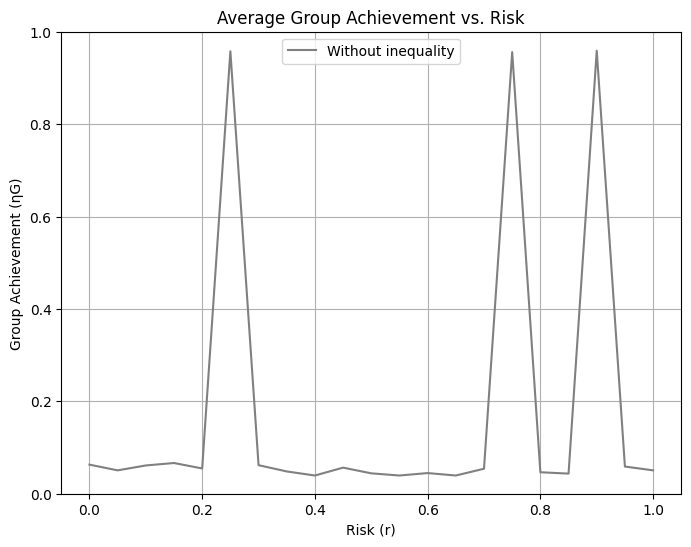

In [10]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(risks, eta_no_inequality, label="Without inequality", color="gray")
# plt.plot(risks, eta_with_inequality_h0, label="With inequality & h=0", color="blue")
# plt.plot(risks, eta_with_inequality_h1, label="With inequality & h=1", color="red")
plt.xlabel("Risk (r)")
plt.ylabel("Group Achievement (ηG)")
plt.title("Average Group Achievement vs. Risk")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()